<a href="https://colab.research.google.com/github/dhivyasreedhar/Music-Instrument-Recognition/blob/main/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
!unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"

Cloning into 'BasicsMusicalInstrumClassifi'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 904 (delta 3), reused 0 (delta 0), pack-reused 895
Receiving objects: 100% (904/904), 14.10 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Archive:  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi.zip
   creating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/mfcc_feature_vectors.pl  
 extracting: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/max_length.pl  
   creating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Ds3_05_fortissimo_arco-normal.mp3  
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_A5

In [ ]:
import librosa
import os,fnmatch
import numpy as np
import pandas as pd

import librosa.display
import IPython.display as ipd

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/


In [ ]:
# Get Labels
labels =[]
classes=['cello','flute','oboe','saxaphone','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'saxaphone':'black', 'trumpet':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

In [ ]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, other, trumpet, viola


In [ ]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

In [ ]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

In [ ]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_A4_05_piano_normal.mp3
get 2 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_A3_05_mezzo-piano_normal.mp3
get 3 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs3_025_forte_normal.mp3
get 4 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs5_1_piano_normal.mp3
get 5 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_025_fortissimo_normal.mp3
get 6 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_A3_05_forte_normal.mp3
get 7 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_mezzo-forte_normal.mp3
get 8 of 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_A3_1_forte_normal.mp3
get 9 of 600 = ./BasicsMusicalInstrumClassifi/audio

In [ ]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (600, 13)


In [ ]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [ ]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


In [ ]:
# KNN Classifier
n_neighbors=1
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [ ]:
# kNN
model_knn.fit(train_set, train_classes);

In [ ]:
# Predict using the Test Set
predicted_labels = model_knn.predict(test_set)

In [ ]:
#Evaluation
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.96 1.   0.96 1.   1.   1.  ]
Precision:  [1.   1.   1.   1.   0.96 0.96]
F1-Score:  [0.98 1.   0.98 1.   0.98 0.98]
Accuracy: 0.99  , 148
Number of samples: 150


# Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
# Recall - the ability of the classifier to find all the positive samples
# F1-Score - The F1 score can be interpreted as a weighted average of the precision and recall

In [ ]:
print(classification_report(test_classes, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       1.00      1.00      1.00        25
           2       1.00      0.96      0.98        25
           3       1.00      1.00      1.00        25
           4       0.96      1.00      0.98        25
           5       0.96      1.00      0.98        25

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

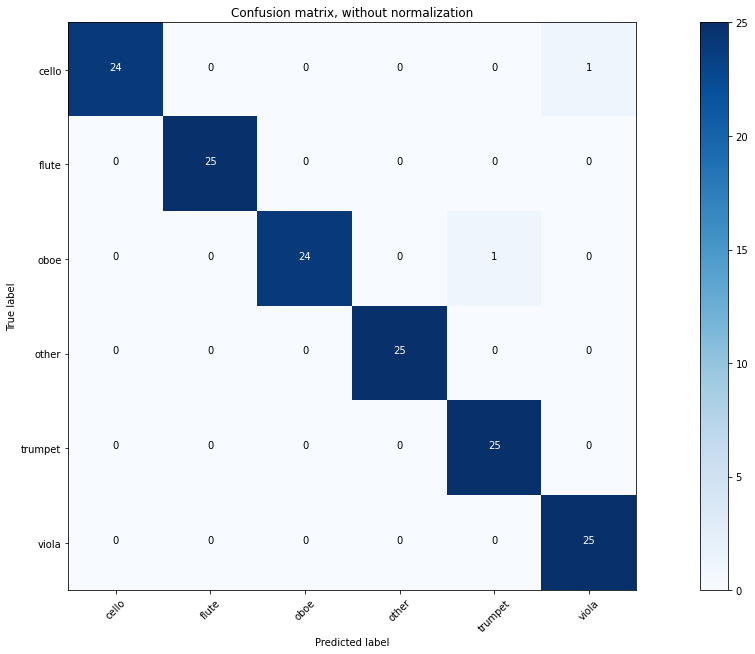

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,9))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['oboe' 'cello']
[4 5]
['trumpet' 'viola']
['./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_05_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-forte_arco-harmonic.mp3']


In [ ]:
#choosing a k value

error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_set, train_classes)
    pred_i = knn.predict(test_set)
    error_rate.append(np.mean(pred_i != test_classes))
    # wherever the pred value is not matching the test class value it will find the mean of that which will give the error rate.

Text(0, 0.5, 'Error Rate')

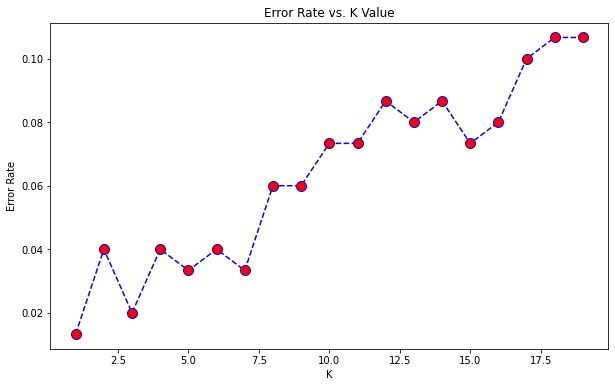

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

From the plot we see that the least stable error rate occurs around k =7 hence we will use k = 7 as the best model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_set, train_classes)
# Predict using the Test Set
predicted_labels = knn.predict(test_set)

In [ ]:
# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Accuracy: 0.97  , 145
Number of samples: 150


In [ ]:
#Evaluation
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [1.   0.96 0.96 0.96 1.   0.92]
Precision:  [0.96 0.96 1.   1.   0.93 0.96]
F1-Score:  [0.98 0.96 0.98 0.98 0.96 0.94]
Accuracy: 0.97  , 145
Number of samples: 150


In [ ]:
print(classification_report(test_classes, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       0.96      0.96      0.96        25
           2       1.00      0.96      0.98        25
           3       1.00      0.96      0.98        25
           4       0.93      1.00      0.96        25
           5       0.96      0.92      0.94        25

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

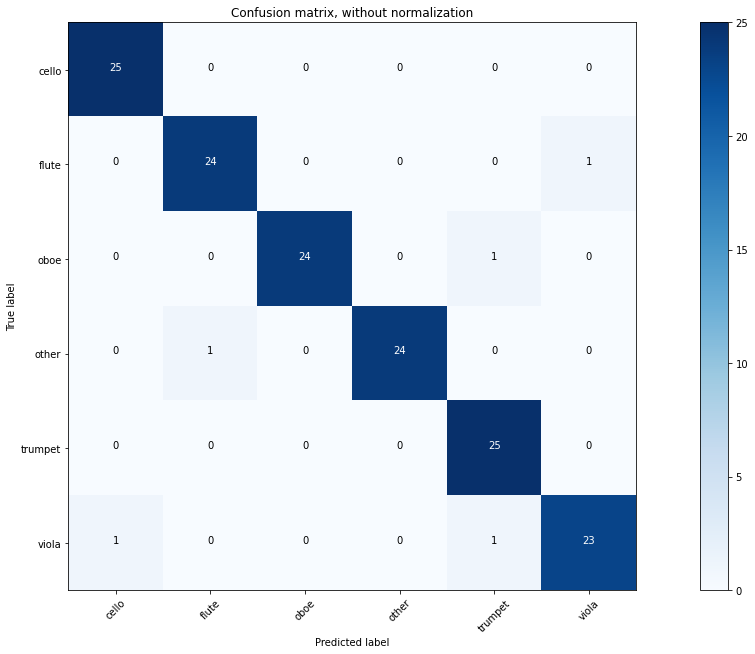

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,9))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['oboe' 'viola' 'flute' 'viola' 'other']
[4 4 5 0 1]
['trumpet' 'trumpet' 'viola' 'cello' 'flute']
['./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_05_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_A4_1_fortissimo_snap-pizz.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs5_025_piano_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs3_025_mezzo-piano_arco-normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_025_mezzo-forte_normal.mp3']
